In [52]:
# import library's 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
# https://pypi.org/project/pca/
from pca import pca
%matplotlib inline


## Exploring the dataset

This dataset is from the US Arrests Kaggle challenge. A description of the
data is given as: “This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

In [175]:
# read countries csv
df = pd.read_csv("UsArrests.csv", index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


In [176]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))
# 

Number of cases: 50 Number of features: 4


The mean, standard deviation, range, and distribution of each variable, as well as the number of missing values per variable, are observed. This is summarised in the table below.

In [177]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
selected_stats = df.describe().loc[["mean","std","min","max"]].transpose() #select relevant rows
# Count missing values
relevant_missing = pd.DataFrame(df.isnull().sum(), columns=["missing"])
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary

,missing,mean,std,min,max
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


At first glance, Assault stands out as having a mean and standard deviation which are significantly higher than the other variables. The data will be scaled to keep assault from impacting the analysis disproportionately.

The statistics for 50 US states are arrest made per 100 000 residents for 3 types of crimes: murder, assault and rape. The objective of this report will be to create an in-depth PCA report, interpret the outcome of any analyses and apply two clustering techniques to examine how each crime attributes itself to each state.  City will be the response variable and crime and population are the predictor variables. 

The info table below shows that the data has 5 features, 0 missing values and mixed data types. 

In [178]:
# understand the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


All predictor variables are converted to the same datatype.

In [179]:
# make numerical features all float types
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')

Below histograms show the distribution of the observations for each feature

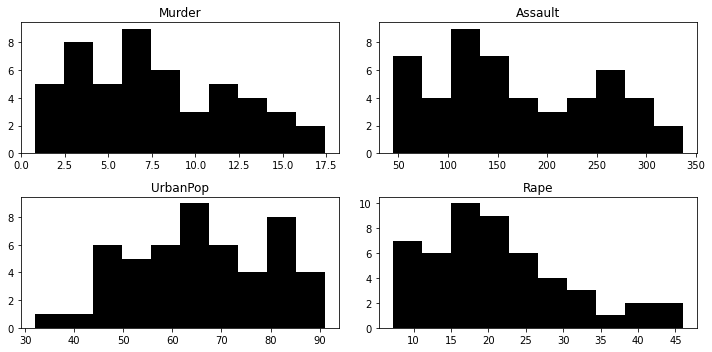

In [180]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(10, 5)) 
plt.tight_layout()

The boxplot below shows spread of the data. We can see that assault has a larger spread and medium compared to the other features. The data will be scaled so that Assault doesn't bias the modals.

Text(0.5, 1.0, 'Data Distribution of the Four features')

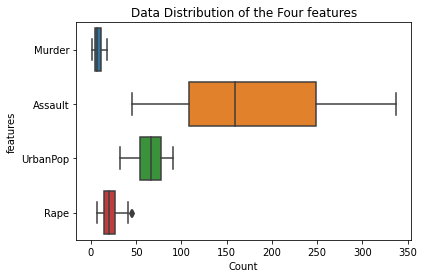

In [181]:
# creating a boxplot for feature distribution
sns.boxplot(data=df, orient='h')
plt.ylabel('features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four features')

Observations:

- top 5 highest murder rate : Georgia, Mississippi, Florida, Louisiana, South Carolina
- top 5 lowest murder rate : North Dakota, New Hampshire, Maine, Iowa, Vermont

- top 5 highest assault :  North Carolina, Florida, Maryland, Arizona, New Mexico
- top 5 lowest assault :  North Dakota, Hawaii, Vermont, Wisconsin, Iowa

- top 5 highest rape : Nevada, Alaska, California, Colorado, Michigan
- top 5 lowest rape : North Dakota, Maine, Rhode Island, West Virginia, New Hampshire

- top 5 highest UrbanPop : California, New Jersey, Rhode Island, New York, Massachusetts
- top 5 lowest UrbanPop : Vermont, West Virginia, North Dakota, Mississippi, South Dakota


CORRELATION ANALYSIS

From the correlation plot, as expected, murder and assault has a strong positive correlation and rape and assault is relatively strong. UrbanPop has a relatively low correlation against all the variables, tracking slightly higher with rape.   Although, it's hard to make comparisons, because UrbanPop is a percentage value representing population of residents within each state, while number of murders, rapes and assaults are all distinct numeric values that are not represented as percentages. Nevertheless, variables with strong correlation suggests that the data may be a good candidate for PCA. PCA will be able to reduce variables which encode similar types of differences between features in a way that requires fewer dimensions.

Text(0.5, 1.0, 'Correlation Heatmap of US Arrests')

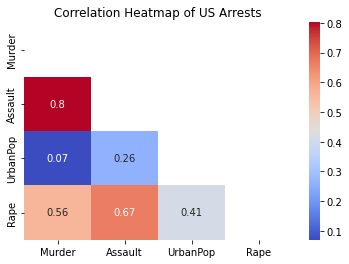

In [182]:
# corr heatmap to see how our data features correlate
cities = df.index
labels = df.columns
arrest_corr = df.corr()
# to mask mirrored side of heatmap
mask_ut=np.zeros_like(arrest_corr)
mask_ut[np.triu_indices_from(mask_ut)] = True
# mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)

# heatmap
sns.heatmap(arrest_corr, mask=mask_ut, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of US Arrests")


Data will be scaled so that one feature doesn't dominate another.

In [183]:
# select independent and standardise features
scaled = StandardScaler().fit_transform(df.loc[:,['Murder', 'Assault', 'UrbanPop', 'Rape']])
# create scaled version of df
df_scaled = pd.DataFrame(scaled, columns = ['Murder', 'Assault', 'UrbanPop', 'Rape'])
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.26,0.79,-0.53,-0.00
1,0.51,1.12,-1.22,2.51
2,0.07,1.49,1.01,1.05
3,0.23,0.23,-1.08,-0.19
4,0.28,1.28,1.78,2.09


## PCA Standardised Data

Components for PCA

The graph below and the explained variance ratio shows component 1 contains 62% of all explained variances within our data. Component 2 contains 24.74% of all explained variance. To principle components achieves 86.74% explanation of variance within our data, which is an acceptable threshold. 

In [184]:
# showing how each component attributes itself to explain variance
pca_modal = PCA().fit(df_scaled)
print(f"Proportion of Variance Explained: {pca_modal.explained_variance_ratio_}")
print(f"Cumulative Proportion: {np.cumsum(pca_modal.explained_variance_)}")


Proportion of Variance Explained: [0.62006039 0.24744129 0.0891408  0.04335752]
Cumulative Proportion: [2.53085875 3.5408232  3.90466318 4.08163265]


Text(2.5, 85.5, '85% threshold')

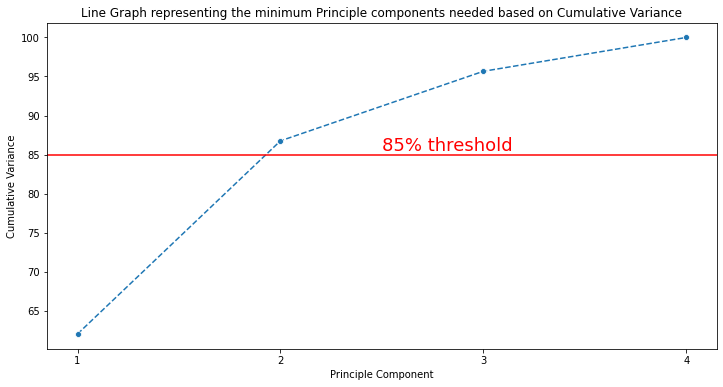

In [185]:
# graph to show the minimum number of components needed for analysis
X = np.arange(1, 5, 1)
plt.figure(figsize=(12,6))
sns.lineplot(x=X, y = np.cumsum(pca_modal.explained_variance_ratio_)*100, linestyle='--', marker='o')

plt.title('Line Graph representing the minimum Principle components needed based on Cumulative Variance')
plt.xlabel('Principle Component')
plt.xticks(np.arange(1, 5, 1))
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color = 'red', fontsize=18) 

The analysis will proceed with 2 components

In [186]:
# PCA analysis 2 components
pca_modal = PCA(n_components=2)

# obtain components
principal_components = pca_modal.fit_transform(df_scaled)
principal_components.shape

(50, 2)

PCA model with n components 2 transformed into a Pandas dataframe, setting state names to index.

In [187]:
# index
cities = df.index
#feature labels
labels = df.columns
# transform the components into a pandas data frame
pc_df = pd.DataFrame(data = principal_components, columns=['principal_component_1', 'principal_component_2'])
pc_df.set_index(cities, inplace=True)
pc_df.head()

,principal_component_1,principal_component_2
City,,
Alabama,0.99,1.13
Alaska,1.95,1.07
Arizona,1.76,-0.75
Arkansas,-0.14,1.12
California,2.52,-1.54


The barplot below shows variance explained by principle components.

<AxesSubplot:title={'center':'Variance Explained by principle components'}, xlabel='principal_component', ylabel='variance_explained'>

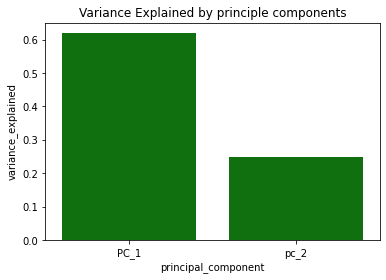

In [188]:
# barplot to visually represent how each component affects the variance
df_var = pd.DataFrame({'variance_explained': pca_modal.explained_variance_ratio_, 'principal_component': ['PC_1', 'pc_2']})
plt.title('Variance Explained by principle components')
sns.barplot(x='principal_component', y='variance_explained', data=df_var, color='g')

In [189]:
# function for biplot us arrest pca data
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(15, 10))    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        # index col
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

The first biblot represents components within the total Dataframe with numeric labels to show correlation.

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.


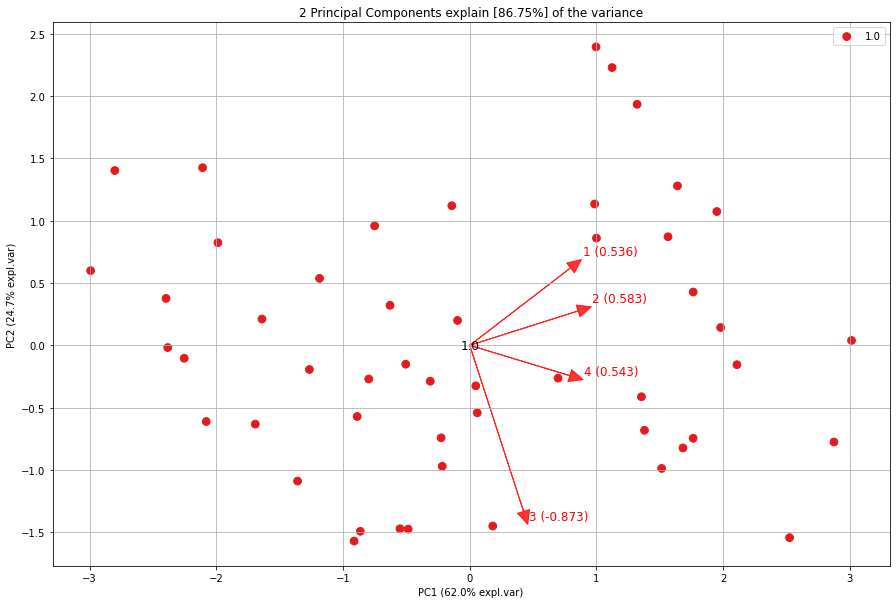

In [190]:
# biblot to represent components within the total Dataframe with numeric labels
model = pca(n_components=2)
# Fit transform
results = model.fit_transform(scaled)
# Plot explained variance
# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)


Second biblot represents components within the total Dataframe with feature labels.

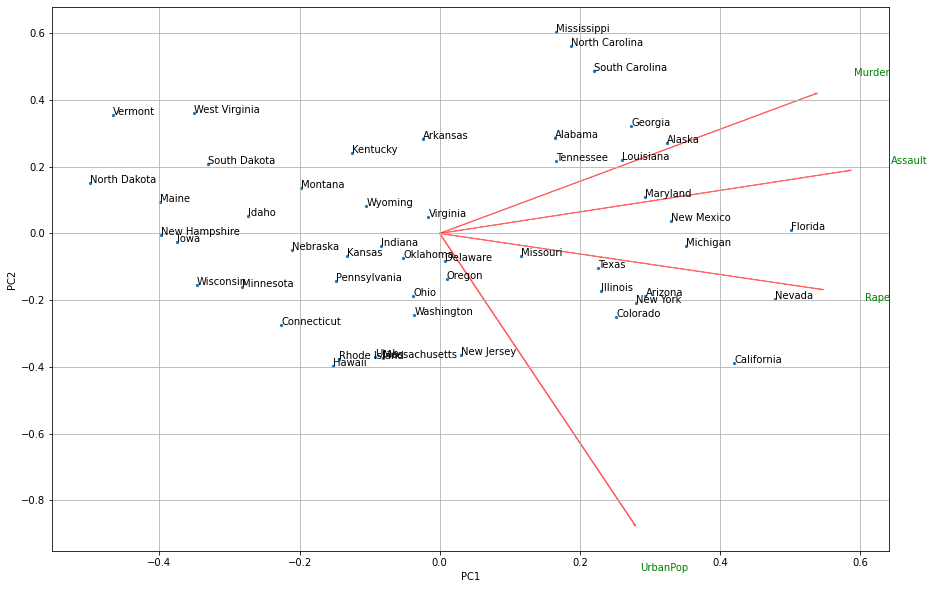

In [191]:
# # biblot to represent components within the total Dataframe with labels
biplot(
    principal_components[:,0:2],
    np.transpose(pca_modal.components_[0:2, :]), 
    labels= labels
)


The above biplots show the observations as points in the plane formed by two principle components. The states are displayed as points. And contains 4 variables Murder, Assault, Rape and Urban Population. 

The cosine of the angle between a vector and an axis indicates the importance of the contribution of the corresponding variable to the principal component. The cosine of the angle between pairs of vectors indicates correlation between the corresponding variables. Highly correlated variables point in similar directions; uncorrelated variables are nearly perpendicular to each other. 

In [192]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca_modal.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca_modal.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance from the above table, it seems that most of the variables contribute fairly evenly, accept UrbanPop in pc1 and pc2 UrbanPop contributing the highest.

## Cluster Analysis

Hierarchical Clustering and K-means will be performed using PCA modal data and the results compared.

# K-means analysis

K-means finds observations that share characteristics and classifies them together into clusters.  To determine k clusters the elbow method will be used. The below elbow method will run k means clustering on the dataset for a range 1 to 10 k values and for each value of k compute an average score for all clusters.  

Text(0, 0.5, 'Reduction in variance')

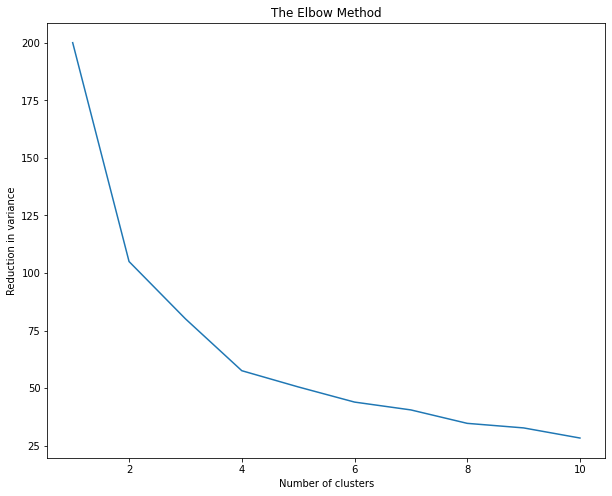

In [193]:
#Finding the optimum number of clusters for k-means classification
#within cluster sum of squares
wcss = []
plt.figure(figsize=(10,8))
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)

lp = sns.lineplot(y=wcss, x=range(1, 11))
lp.set_title('The Elbow Method')
lp.set_xlabel('Number of clusters')
lp.set_ylabel('Reduction in variance') #within cluster sum of squares



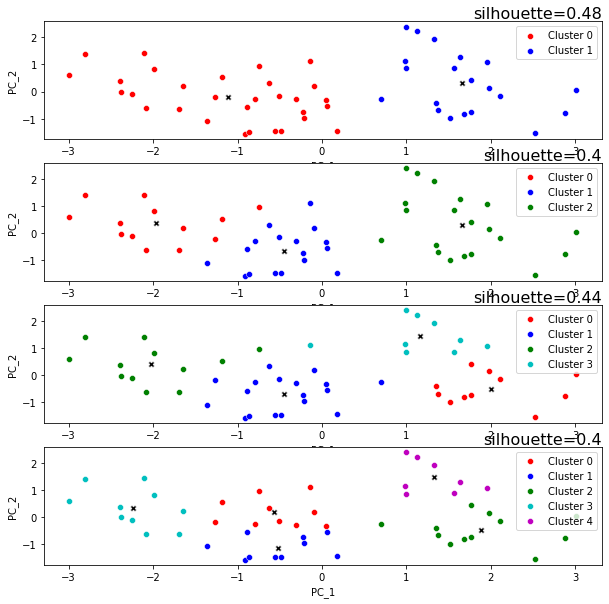

In [194]:
def scatter_Kmeans(x, k, i, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init = 10, random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      sp = sns.scatterplot(
        x=x[y_pred == c, 0], 
        y=x[y_pred == c, 1], 
        c = colours[c], 
        label = f'Cluster {c}', 
        ax=ax[i])

    sp = sns.scatterplot(
      x=[cluster[0] for cluster in kmeans.cluster_centers_], 
      y=[cluster[1] for cluster in kmeans.cluster_centers_], 
      marker='X', 
      c = 'black', 
      ax=ax[i]
    )
    
    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
    
    sp.set_title(f'silhouette={score}', loc='right', fontdict={'fontsize': 16}, pad=-14)
    sp.set_xlabel('PC_1')
    sp.set_ylabel('PC_2') #within cluster sum of squares
    sp

k_test = range(2,6)    
fig, ax = plt.subplots(len(k_test), 1, figsize=(10, 10))
for i, k in enumerate(k_test):
  scatter_Kmeans(principal_components, k, i, r=0)

n_clusters 4 and 2 was chosen for investigation based on the highest sihouette score and the elbow method graph.  

K-means model with 4 n_clusters:

No handles with labels found to put in legend.


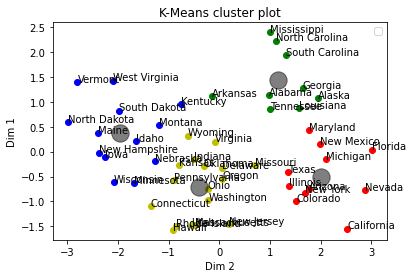

In [195]:
# We extract the first two components
x = principal_components[:,0]
y = principal_components[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', n_init =10, random_state=42)
cluster_labels = kmeans.fit_predict(pc_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 
    ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='o', c = "black", s=300, alpha=0.5)
for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

Silhouette score

In [196]:
print(f'Silhouette score: {silhouette_score(principal_components, cluster_labels)}')

Silhouette score: 0.4438350783806996


Below code adds cluster information to original dataframe for investigating.

In [197]:
# indexes are grouped by elements, assigned cluster group
# adds cluster group to df
def add_cluster_groups(modal_fit, col_name):
    group0_indices = np.argwhere(modal_fit==0).transpose()[0]
    group1_indices = np.argwhere(modal_fit==1).transpose()[0]
    group2_indices = np.argwhere(modal_fit==2).transpose()[0]
    group3_indices = np.argwhere(modal_fit==3).transpose()[0]

    group0 = np.array(cities)[group0_indices]
    group1 = np.array(cities)[group1_indices]
    group2 = np.array(cities)[group2_indices]
    group3 = np.array(cities)[group3_indices]

    # add cluster group to dataframe
    for c in cities:
        if c in group0:
            df.at[c, col_name] = 1
        elif c in group1:
            df.at[c, col_name] = 2
        elif c in group2:
            df.at[c, col_name] = 3
        elif c in group3:
            df.at[c, col_name] = 4
        else:
            df.at[c, col_name] = 99

Summary of the data grouped by clusters.

In [199]:
# add cluster groups for k = 4 to df
add_cluster_groups(cluster_labels, 'k_4cluster')

# mean summary cluster k=4
#     .agg(["mean","std","min","max"])
(
    df
    .groupby(['k_4cluster'])
    .mean()
    .reset_index()
)

,k_4cluster,Murder,Assault,UrbanPop,Rape
0,1.000,11.055,264.091,79.091,32.618
1,2.000,3.600,78.538,52.077,12.177
2,3.000,13.500,245.778,53.111,23.978
3,4.000,5.853,141.176,73.647,19.335


<AxesSubplot:xlabel='k_4cluster', ylabel='UrbanPop'>

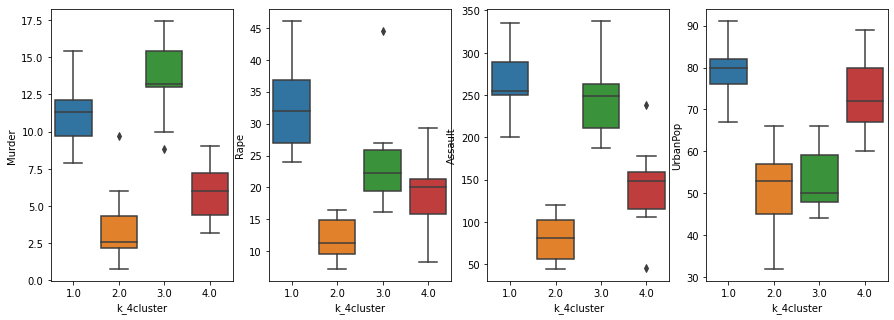

In [200]:
# Boxplots to display distribution of crime rates for the states in cluster 1 to 4.
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(15,5))
sns.boxplot(x='k_4cluster', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='k_4cluster', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='k_4cluster', y='Assault', data=df, ax=ax[2])
sns.boxplot(x='k_4cluster', y='UrbanPop', data=df, ax=ax[3])


From the box plots above, 

Cluster 1 states has higher rates of arrest across all features and higher UrbanPop.  Cluster 4 states also has relatively higher UrbanPop, but interesting has relatively low rates of arrest across all features compared to cluster 1.

Cluster 2 states has relatively low rates of arrest across all features and lower medium urbanPop compared to clusters 1 and 4. And a larger spread of states with lower percentage score in urbanPop.

Cluster 3 has relatively high rates of arrest across all features, but lower urbanPop.

The plot also shows some outliers in the data.

K-means model with 2 n_clusters:

No handles with labels found to put in legend.


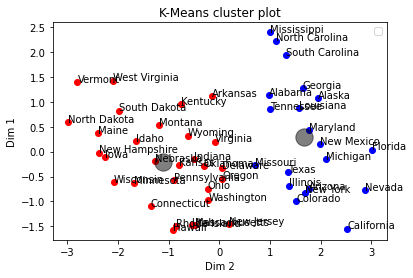

In [201]:
# We extract the first two components
x = principal_components[:,0]
y = principal_components[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', n_init =10, random_state=42)
cluster_labels2 = kmeans.fit_predict(pc_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels2 == i],y[cluster_labels2 == i],c = colours[i]) 
    ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='o', c = "black", s=300, alpha=0.5)


for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

Silhouette score for k =2

In [202]:
print(f'Silhouette score: {silhouette_score(principal_components, cluster_labels2)}')

Silhouette score: 0.4758031477075562


In [203]:
# add cluster groups for k = 2 to df
add_cluster_groups(cluster_labels2, 'k_2cluster')

Summary of the data grouped by k=2 clusters.

In [204]:
# summary df
(
    df
    .drop(['k_4cluster'], axis=1)
    .groupby(['k_2cluster'])
    .mean()
    .reset_index()
)

,k_2cluster,Murder,Assault,UrbanPop,Rape
0,1.000,4.870,114.433,63.633,15.943
1,2.000,12.165,255.250,68.400,29.165


<AxesSubplot:xlabel='k_2cluster', ylabel='UrbanPop'>

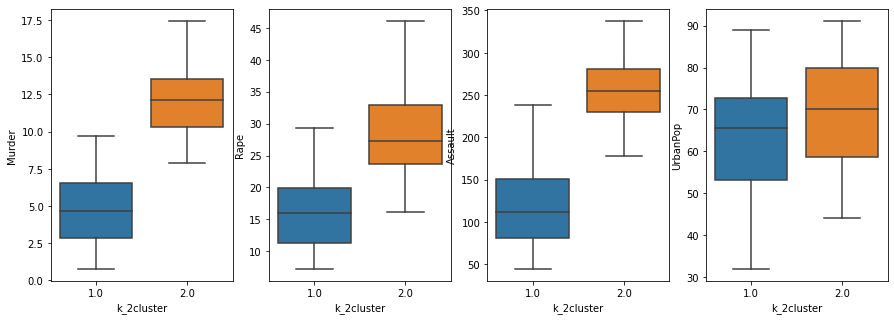

In [205]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(15,5))
sns.boxplot(x='k_2cluster', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='k_2cluster', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='k_2cluster', y='Assault', data=df, ax=ax[2])
sns.boxplot(x='k_2cluster', y='UrbanPop', data=df, ax=ax[3])

From the box plots above, 

The states in cluster 1 has lower min/max and medium values for Murders,Assaults and Rapes compared to cluster 2.
The states in the cluster 2 has higher crime rates on average. There is some overlap, but on average cluster 2 can be categorized as high-risk States. Cluster 1 has a slightly lower medium and mean to cluster 2 for UrbanPop. It has a much larger spread and a lower min.  

## Hierarchical clustering

Agglomerative clustering using PCA data

Below we see the clusters visually in a dendrogram. In order to determine the method used to measure the distance between clusters, we plotted the various dendrograms for complete and average linkage methods. For the distance metric between observations, Euclidean and cityblock was used.

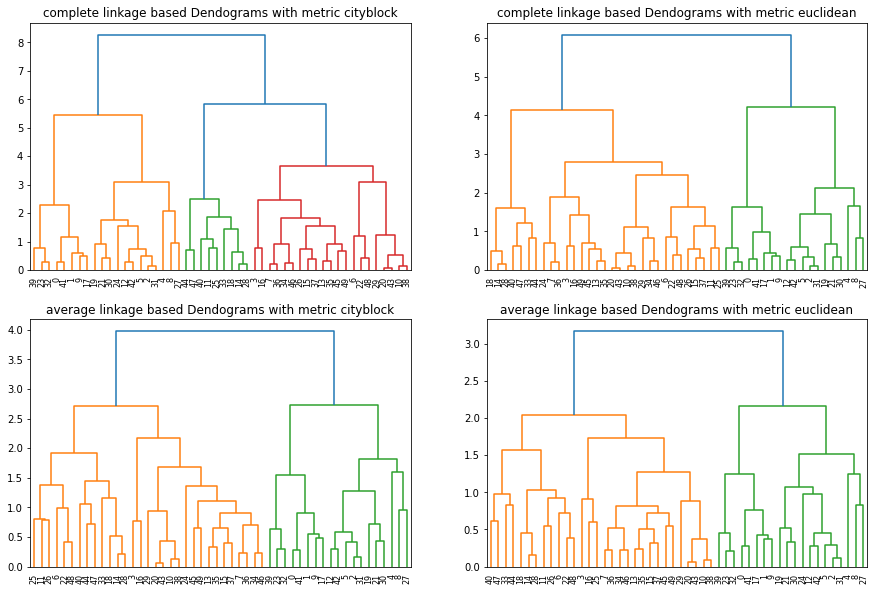

In [206]:
# plot dendrogram
# Using single and complete linkages, 
# and Euclidean and Cityblock distance metrics
linkage_types = ['complete', 'average']
metric_type = ['cityblock', 'euclidean']

f, ax = plt.subplots(2, 2, figsize=(15, 10))
for i, l in enumerate(linkage_types):
    for j, m in enumerate(metric_type):
        dend = dendrogram(linkage(principal_components, method=l, metric=m), ax=ax[i, j]) # left out labels=pc_df.index for neatness,
        ax[i, j].set_title(f'{l} linkage based Dendograms with metric {m}')

I have chosen metric cityblock and linkage complete, based on looking at the dendogram using those parameters I will investigate using n clusters 3.  

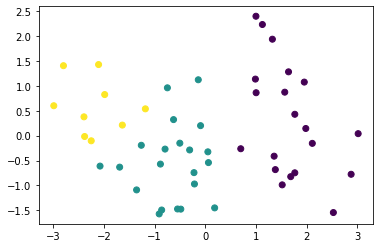

In [207]:
# agglomerative hierarchical clustering cityblock, complete, 3 n cluster
model_agg = AgglomerativeClustering(n_clusters=3, metric='cityblock', linkage="complete")
model_agg.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=model_agg.labels_)

Silhoette score for n cluster=3. The silhouette score indicates a weak structure of the clusters. 

In [208]:
cl = model_agg.fit_predict(principal_components)
print(f'Silhouette score: {silhouette_score(principal_components, cl)}')

Silhouette score: 0.404075780365741


No handles with labels found to put in legend.


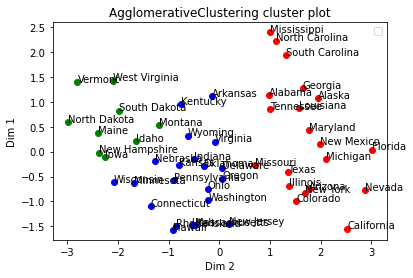

In [209]:
# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,3):
    ax.scatter(x[cl == i],y[cl == i],c = colours[i]) 
for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("AgglomerativeClustering cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [210]:
# add cluster groups for k = 3 to df
add_cluster_groups(cl, 'agg_3cluster')

<AxesSubplot:xlabel='agg_3cluster', ylabel='UrbanPop'>

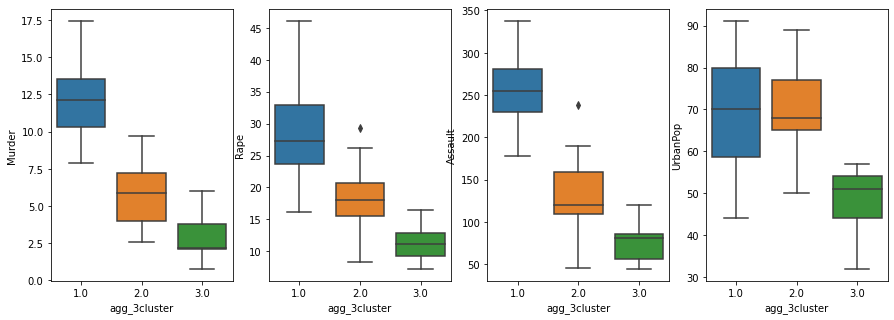

In [211]:
# Boxplots to display distribution of crime rates for the states in cluster 1-3.
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(15,5))
sns.boxplot(x='agg_3cluster', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='agg_3cluster', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='agg_3cluster', y='Assault', data=df, ax=ax[2])
sns.boxplot(x='agg_3cluster', y='UrbanPop', data=df, ax=ax[3])

The boxplot above shows 3 distinct groups. Cluster one shows relative higher arrest and UrbanPop. The spread of the data is relatively big, which makes sense as the Silhouette score is weak. Cluster two relatively low arrest, but high UrbanPop.  Whereas, cluster three scores lowest across all features. There are outliers in cluster two.  

The dendrogram are not a perfect system for choosing n clusters. I also wanted to compare distinct cluster groups to my K-Means model (k=4), so have included n clusters 4, metric cityblock and linkage complete to investigate further.

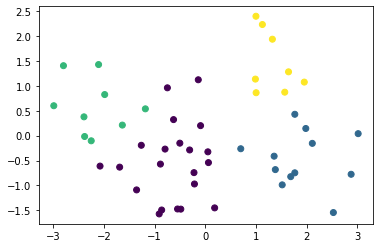

In [212]:
# agglomerative hierarchical clustering cityblock, complete, 4 n cluster
model_agg_4 = AgglomerativeClustering(n_clusters=4, metric='cityblock', linkage="complete")
model_agg_4.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=model_agg_4.labels_)

In [213]:
# silhouette score
cl_4 = model_agg_4.fit_predict(principal_components)
print(f'Silhouette score: {silhouette_score(principal_components, cl_4)}')

Silhouette score: 0.42185754446375023


No handles with labels found to put in legend.


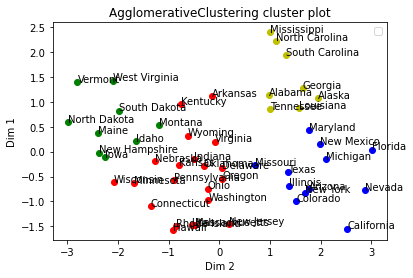

In [214]:
# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,4):
    ax.scatter(x[cl_4 == i],y[cl_4 == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("AgglomerativeClustering cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [215]:
# add cluster groups for k = 4 to df
add_cluster_groups(cl_4, 'agg_4cluster')

<AxesSubplot:xlabel='agg_4cluster', ylabel='UrbanPop'>

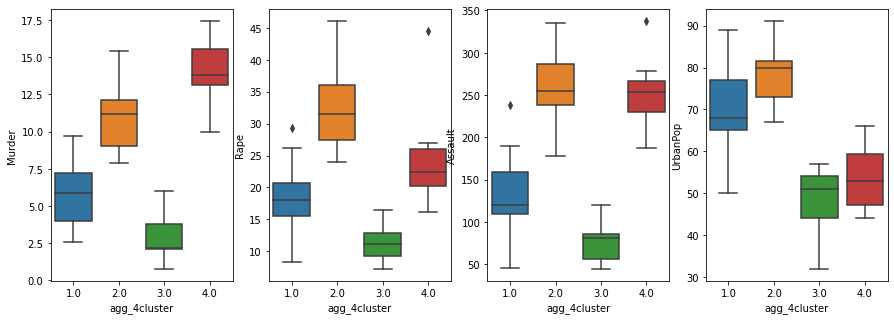

In [216]:
# Boxplots to display distribution of crime rates for the states in cluster 1-4.
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(15,5))
sns.boxplot(x='agg_4cluster', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='agg_4cluster', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='agg_4cluster', y='Assault', data=df, ax=ax[2])
sns.boxplot(x='agg_4cluster', y='UrbanPop', data=df, ax=ax[3])

Cluster 1 states has lower rates of arrest across all features, but higher UrbanPop.  Cluster 2 relatively high across all features.  Cluster 3 states has lower rates of arrest across all features. Cluster 4 high murder, but medium score rape, high assault and low UrbanPop compared to cluster 1 and 2, but higher than cluster 3.

The plot also shows some outliers in the data

I also wanted to compare distinct cluster groups to my K-Means model (k=2), so have included n clusters 2, metric cityblock and linkage complete to investigate further.

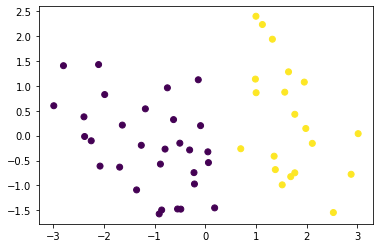

In [217]:
# agglomerative hierarchical clustering cityblock, complete, 4 n cluster
model_agg_2 = AgglomerativeClustering(n_clusters=2, metric='cityblock', linkage="complete")
model_agg_2.fit_predict(principal_components)
plt.scatter(principal_components[:,0], principal_components[:,1], c=model_agg_2.labels_)

In [218]:
# silhouette score
cl_2 = model_agg_2.fit_predict(principal_components)
print(f'Silhouette score: {silhouette_score(principal_components, cl_2)}')

Silhouette score: 0.4758031477075562


No handles with labels found to put in legend.


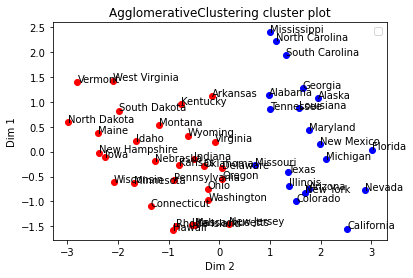

In [219]:
# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,2):
    ax.scatter(x[cl_2 == i],y[cl_2 == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("AgglomerativeClustering cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [220]:
# add cluster groups for k = 2 to df
add_cluster_groups(cl_2, 'agg_2cluster')

<AxesSubplot:xlabel='agg_2cluster', ylabel='UrbanPop'>

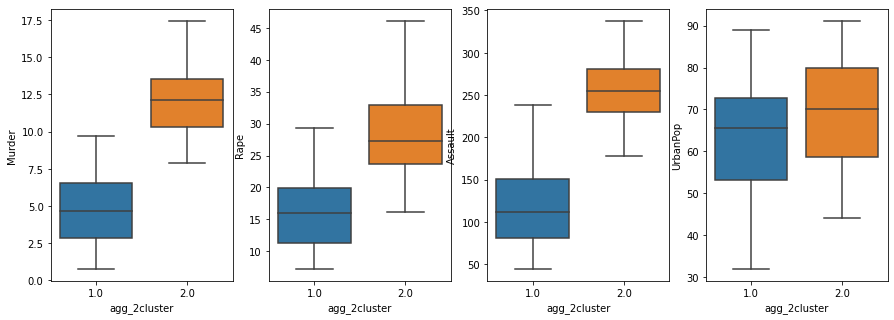

In [221]:
# Boxplots to display distribution of crime rates for the states in cluster 1-3.
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(15,5))
sns.boxplot(x='agg_2cluster', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='agg_2cluster', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='agg_2cluster', y='Assault', data=df, ax=ax[2])
sns.boxplot(x='agg_2cluster', y='UrbanPop', data=df, ax=ax[3])

From the box plots above, 

The states in cluster 1 has lower min/max and medium values for Murders,Assaults and Rapes compared to cluster 2.
The states in the cluster 2 has higher crime rates on average. There is some overlap, but on average cluster 2 can be categorized as high-risk States. Cluster 1 has a slightly lower medium and mean to cluster 2 for UrbanPop. It has a much larger spread and a lower min.  

## Summary

I investigated US Arrests made in 1973 per 100 000 people within each of the 50 cities. This was done using unsupervised learning models; Principle Component Analysis, K-means and hierarchical clustering.

Based on the results both hierarchical clustering and K-means grouped the states together similarly. In both models when running 2 clusters the groups were roughly split into low and high arrest per 100 000. There was some grouping between high and low UrbanPop, but not definitive.  The larger clusters 3 and 4 grouped similarly as above roughly splitting into low and high arrest per 100 000. However, there was more distinction between low and high UrbanPop. You could see some states grouped with low arrest and higher UrbanPop, high arrest and high UrbanPop, high arrest states and low UrbanPop.  A traffic light system red, amber and green would be a good way to virtualize the groupings in terms of lower (green), medium (amber) and red (higher) arrest states. 

The Silhouette score was weak. model_agg_2 scored the highest with 48.  This makes sense when looking at the boxplots as the spread of the data is wide, and there are outliers. Nevertheless, both models are still informative and show some patterns though not definitive, and therefore you would need additional analysis to make any assertions based on the data.